In [1]:
#Import needed modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#Importing data to variables to dataframe and numpy arrays.
data = np.genfromtxt('data\chess-games.csv')
datanames = pd.read_csv('data\chess-games-names.csv', header=None)
chessname = np.copy(datanames)
chessdata = np.copy(data)


In [2]:
#Grapping names only from original data
name_lst = []
for name in chessname:
    name_lst.append(name[1])

In [3]:
def make_transitionmat(chessdata):
    """
    make_transitionmat function takes in the chessdata as argument the function will then
    sort the dataframe into a NxN transition matrix and return it.
    """
    
    #Initate empty 291X291 matrix (all players)
    A = np.zeros((291,291))
    #each row containing player id white, black and if win/tie/loss
    for match in chessdata:
        #If white won then black lost, holding row(black id) and column (white id)
        if match[2] == 1:
            #Typecasting to int because data is taken as string.
            row = int(match[1])
            column = int(match[0])
        #If black won then white lost, holding row(white id) and column (black id)
        elif match[2] == 0:
            row = int(match[0])
            column = int(match[1])
            
            #Filter out ties.
        if match[2] != 0.5:
            #Adding +1 on all lost matches on rows and columns.
            A[row,column] += 1
            
    #Normalizing each row.
    for i in range(291):
        A[i,:] *= 1/A[i,:].sum()

    return A
A = make_transitionmat(chessdata)

In [4]:
def power_method(A, iterations, init_vec = None):
    """
    power_method takes the transition matrix, the amount of iterations and a initial vector as arguments,
    if there is no initial vector given the function will assignt a fair initial vector as 1/N on each row.
    The function will return the steady state vector if it converges.
    """
    
    A = A.T
    if init_vec == None:
        init_vec = np.ones_like(A[0])/len(A)
    for i in range(iterations):
        AA = np.linalg.matrix_power(A,i)
        AAA = AA@init_vec
    return AAA


#Making a new pandas dataframe with the steady state vector. Then adding chess player names in first column and the rank given from the power method in the second column
#Then sorting from highest to lowest rank.
df_new = pd.DataFrame(power_method(A, 100))
df_new[0] = name_lst
df_new['Rank'] = power_method(A, 100)
df_new.columns = ['Player','Rank']
df_new1 = np.copy(df_new)
df_new1 = pd.DataFrame(df_new1)
df_new1.columns = ['Player','Rank']
df_new1 = df_new1.sort_values(by=['Rank'],ascending=False)
df_new1.head(n = 10)

,Player,Rank
1,Karjakin Sergey,0.0770343
17,Svidler Peter,0.0644529
73,Andreikin Dmitry,0.0606796
128,Aronian Levon,0.0581414
178,Matlakov Maxim,0.0563554
2,Ivanchuk Vassily,0.0447092
131,Kramnik Vladimir,0.0411574
29,Vachier-Lagrave Maxime,0.0409471
54,Tomashevsky Evgeny,0.0335337
157,Areshchenko Alexander,0.0318338


In [5]:
def google_mat(alpha, S):
    """
    google_mat takes a tuning scalar with values from 0 to 1 and the stochastic transition matrix as arguments.
    The function will take the google algorithm and return the google transition matrix.
    """
    
    e = np.ones(len(S))
    E = 1/len(S)*np.outer(e,e)
    G = alpha*S + (1-alpha)*E
    return G


def check_stochasticity(A):
    """
    check_stochasticity checks if the matrix is stochastic by summing all rows and checks if this equals one.
    Since this is numeric i have a threshold of 0.1 because some values might be 0.99 etc, 
    but want it to fail if it is too low like 0.8 etc.
    """
    
    column = 1
    testcheck = 0
    threshold = 1e-1
    for row in A:
        threshold_test = abs(1-row.sum())
        if threshold_test > threshold:
            print('Sum of row in column %d does not equal one!'%column)
            testcheck = 1
        
    column += 1
    if testcheck == 0:
        print('Test finished: Matrix is stochastic')

#Checking if the matrix is stochastic before i use it in google alogrithm function.
check_stochasticity(A)

#Make new variable with the google transition matrix with tuning 0.85 and 100 iteration. Then assign new pandas dataframe,
#with the steady state google vector. The dataframe is then given the column names "Players" and rank. The dataframe is then sorted from highest to lowest rank.
df_make_google_matrix = google_mat(0.85, A)
df_new_google = pd.DataFrame(power_method(df_make_google_matrix, 100))
df_new_google[0] = name_lst
df_new_google['Rank'] = power_method(df_make_google_matrix, 100)
df_new_google.columns = ['Player','Rank']
#Changing name of dataframe to avoid using the ordered dataframe in regression model.
df_new_google1 = np.copy(df_new_google)
df_new_google1 = pd.DataFrame(df_new_google1)
df_new_google1.columns = ['Player','Rank']
df_new_google1 = df_new_google1.sort_values(by=['Rank'],ascending=False)
df_new_google1.head(n = 10)


Test finished: Matrix is stochastic


,Player,Rank
1,Karjakin Sergey,0.0569849
17,Svidler Peter,0.0539471
73,Andreikin Dmitry,0.0376787
128,Aronian Levon,0.0369885
2,Ivanchuk Vassily,0.0345631
29,Vachier-Lagrave Maxime,0.0317558
178,Matlakov Maxim,0.0303571
131,Kramnik Vladimir,0.025497
54,Tomashevsky Evgeny,0.0224247
10,Grischuk Alexander,0.0222977


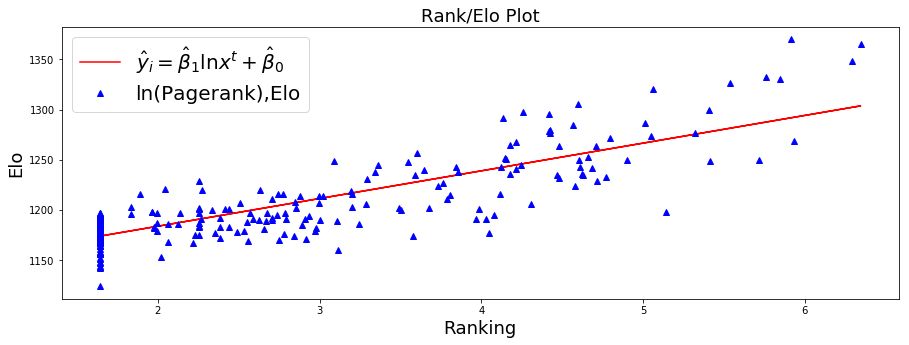

In [6]:
#Importing matplotlib module for plotting
import matplotlib.pyplot as plt

#Importing the chess elo data assigning the chess data to a pandas dataframe and renaming columns to Players and Elo rank.
chess_elo = pd.read_csv('data\chess-games-elo.csv', header = None)
df_chess_elo = pd.DataFrame(chess_elo)
df_chess_elo.columns = ['Player', 'Elo']
# Performing np.copy is to avoid changing the original data.
X = np.copy(df_chess_elo)

#Taking logarithm of the data and multiplying with 
Rank_temp = np.log(np.copy(df_new_google['Rank'])*10**4)

def linearfit_estimate(X):
    """
    linearfit_estimate takes the matrix with players and elo as argument, the function then sorts the matrix for
    vectorized regression model, it will then return the whole regression model y as a array.
    Here we assume gaussian distributed error so that we can minimize the error and use the following multiplications."""
    
    player_temp = np.copy(df_chess_elo['Player'])
    #Assigning the r vector with the steady vector of the google transition matrix and the regular one.
    r = np.copy(df_chess_elo['Elo'])
    ones = np.ones_like(r)
    #Rearranging the matrix to have ones in first column and elo ranks i second (using the logarithm of the data in the regression line).
    A = np.array((ones,Rank_temp)).T
    
    w = (np.linalg.inv(A.T@A))@A.T@r
#     Returning the linear regression model
    
    return w



# Performing the linear regression on the chess elo data.
# The regression model is plotted with the logarithmic paramater, then the google steady state values are plotted with the regression model on a logarithmic y-scale.
reg_coeffs = linearfit_estimate(X)
regline_goog = reg_coeffs[1]*Rank_temp + reg_coeffs[0]
plt.figure(figsize = (15,5))
plt.plot(Rank_temp,regline_goog, label = r'$\hat{y}_{i} = \hat{\beta}_{1}\lnx^{t} + \hat{\beta}_{0} $', color = 'red')
plt.plot(Rank_temp,df_chess_elo['Elo'],'^', label = 'ln(Pagerank),Elo', color = 'blue')
plt.legend(loc = 'best', prop={'size': 20})
# plt.xscale('log')
plt.title('Rank/Elo Plot',fontsize=18)
plt.ylabel('Elo',fontsize=18)
plt.xlabel('Ranking',fontsize=18)
# axes = plt.gca()
# axes.set_ylim([0.0003,1])
plt.show()

In [7]:
def residual(regline):
    """
    residual function takes in the steady state vector and the regression model as arguments
    the function then finds the residual by find the difference between the model and the data.
    Then it find the residual sum of squares and the total sum of squares and then finding the R^2.
    
    #https://en.wikipedia.org/wiki/Residual_sum_of_squares
    #https://en.wikipedia.org/wiki/Coefficient_of_determination
    """
    
    r = np.copy(df_chess_elo['Elo'])
    resid = []
    for i,j in zip(r,regline):
        resid.append(j-i)
    resid = np.array(resid)
    SSres = sum(resid**2)
    SStot = sum((r - np.mean(r))**2)
    #Relative square error used to find the R^2
    E_RSE = SSres/SStot
    R_Sqr = 1 - E_RSE
    
    return R_Sqr


#print out the coefficient of determination R^2 and the estimators of the regression model for the google vector
print('R^2 Google',residual(regline_goog))
print('Beta_0_hat = ',reg_coeffs[0])
print('Beta_1_hat = ',reg_coeffs[1])

R^2 Google 0.721446886994
Beta_0_hat =  1128.80571481
Beta_1_hat =  27.5725796107


# Task 2

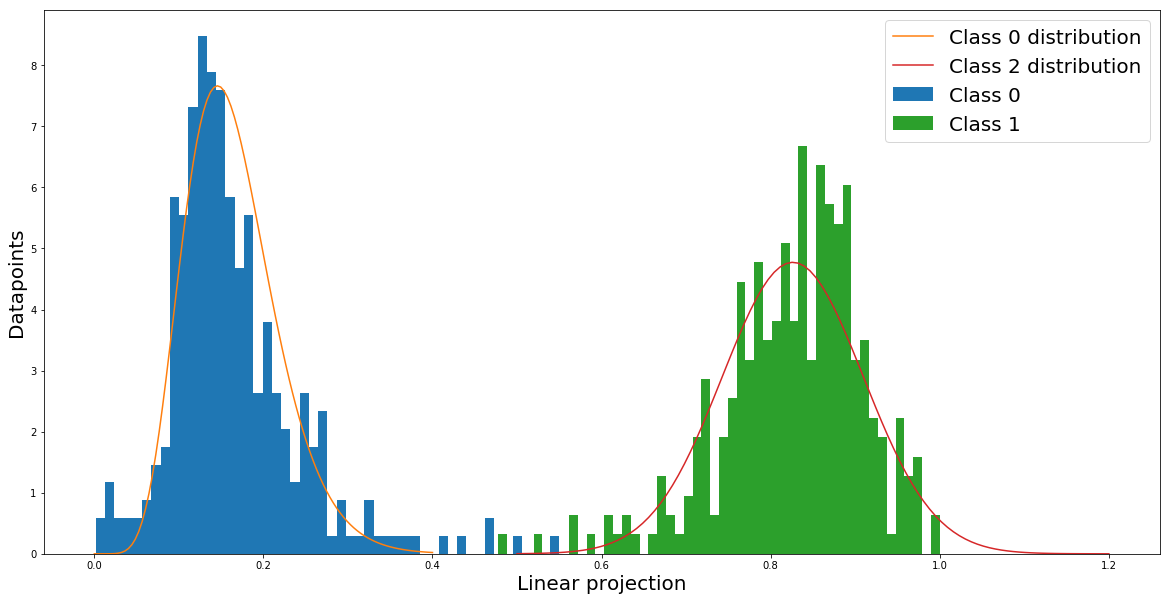

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

#Import data
data = np.genfromtxt('data\optdigits-1d-train.csv')
alpha = 9

#putting each class in its own list for finding priors and for training
C0 = []
C1 = []
#sorting classes
for i in data:
    if i[0] == 0:
        C0.append(i[1])
        
    elif i[0] == 1:
        C1.append(i[1])
        
C0 = np.array(C0)
C1 = np.array(C1)
#Priors for each class
C0_prior = len(C0)/(len(C0)+len(C1))
C1_prior = len(C1)/(len(C0)+len(C1))

#The estimated parameters for gamma distribution and normal distribution
beta = (1/(len(C0)*alpha))*sum(C0)
mu = (1/len(C1))*sum(C1)
variance = (1/len(C1))*sum((C1-mu)**2)    


def gammadistr(x,alpha,beta):
    """
    The gammadistr function takes in the datapoint or an numpy array, alpha parameter and the beta parameter as arguments
    the result of the gamma distribution is then returned.
    """
    #as long as alpha is bigger then 0 and integer
    Tau_alpha = math.factorial(alpha - 1)
    result = (1/(beta**alpha*Tau_alpha))*x**(alpha-1)*np.exp(-x/beta)
    return result



def normaldistr(x,mu,variance):
    """
    The normaldistr function takes in the data point or an numpy array, mu and variance parameters
    the function the returns the values of the normal distribution.
    """
    result = (1/(np.sqrt(2*np.pi*variance)))*np.exp(-((x - mu)**2)/(2*variance))
    return result


#values to plot the 'continues' distributions
x1 = np.linspace(0.5,1.2,100)
x = np.linspace(0,0.4,100)


#values to plot the 'continues' distributions
P_C0 = gammadistr(x,alpha,beta)
P_C1 = normaldistr(x1,mu,variance)


#Plotting the histogram and distributions together in one plot
plt.figure(figsize = (20,10))
plt.hist(C0, bins = 50, label = 'Class 0',density = True)
plt.plot(x,P_C0, label = 'Class 0 distribution')
plt.hist(C1,bins = 50, label = 'Class 1',density = True)
plt.plot(x1,P_C1, label = 'Class 2 distribution')
plt.legend(loc = 'best', prop={'size': 20})
plt.ylabel('Datapoints',fontsize = 20)
plt.xlabel('Linear projection',fontsize = 20)
plt.show()



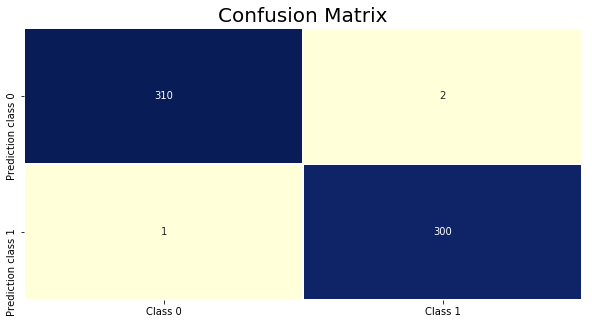

Accuracy of the prediction:  0.995106035889


In [9]:
#Import seaborn to make nice confusion matrix
import seaborn as sns

#Importing training data
data = np.genfromtxt('data\optdigits-1d-train.csv')


def bayes_class(data,alpha,beta,mu,variance,C0_prior,C1_prior):
    """
    The bayes_class function takes in the data, alpha and beta parameters for the gamma distribution
    and the mu and variance of the normal distribution, and the prior probability for class 0 and for class1.
    The data is then classified using the bayes theorem without the equal terms.
    Here the results is added into a result list where the output is zero for class 0 and one for class 1.
    """
    
    result = []
    for x in data:
        P_C0 = gammadistr(x,alpha,beta)
        P_C1 = normaldistr(x,mu,variance)

        if C0_prior*P_C0 > C1_prior*P_C1:
            result.append(0)
        else:
            result.append(1)
            
        
    return result

#Adding training data to the classifier
C0_bayes = bayes_class(C0,alpha,beta,mu,variance,C0_prior,C1_prior)
C1_bayes = bayes_class(C1,alpha,beta,mu,variance,C0_prior,C1_prior)


def confusion_matrix(data0_train,data1_train):
    """
    The confustion_matrix function takes in the training data for class 0 and training data for class 1
    then the data is training with the classifier and the results are sorted in a 2x2 matrix with the True positives and True negatives
    are given on the diagonal axis.
    """
    data0_train = bayes_class(data0_train,alpha,beta,mu,variance,C0_prior,C1_prior)
    data1_train = bayes_class(data1_train,alpha,beta,mu,variance,C0_prior,C1_prior)
    
    confusion_mat = np.zeros((2,2))
    class0_0 = 0
    class0_1 = 0
    class1_1 = 0
    class1_0 = 0
    #Sorting the results
    for i in data0_train:
        if i == 0:
            confusion_mat[0,0] += 1
        else:
            confusion_mat[0,1] += 1
    for i in data1_train:
        if i == 1:
            confusion_mat[1,1] += 1
        else:
            confusion_mat[1,0] += 1
    
    return confusion_mat

    
    
#Setting up the confusion matrix
df_cm = pd.DataFrame(confusion_matrix(C0,C1), index = [i for i in ["Prediction class 0","Prediction class 1"]],
                  columns = [i for i in ["Class 0","Class 1"]])

#plotting the confustion matrix with seaborn heatmap
plt.figure(figsize = (10,5))
sns.heatmap(df_cm, linewidths=1 , cmap="YlGnBu",cbar=False, annot=True,fmt='g', annot_kws={"size": 10})
plt.title('Confusion Matrix',fontsize = 20)
plt.show()


#Finding the accuracy of the prediction
#https://en.wikipedia.org/wiki/Confusion_matrix
#Taking the sum of the true positives and negatives divided by the total population
Population = sum(sum(confusion_matrix(C0,C1)))
Accuracy = sum(np.diag(confusion_matrix(C0,C1)))/Population

print('Accuracy of the prediction: ',Accuracy)


In [10]:
#Importing the utility python module.
from he1_util import get_msg_for_labels

#Importing the test data
data_test = np.genfromtxt('data\optdigits-1d-test.csv')

#Printing out the secret message
print('The secret message is,',get_msg_for_labels(bayes_class(data_test,alpha,beta,mu,variance,C0_prior,C1_prior)))




The secret message is, nevergonnagiveymuup
